# SIR network dynamics (vectorized)

In [1]:
import networkx as nx
# NOTE you will probably need to install the networkx package manually, not a standard package
import numpy as np
import time
from matplotlib import pyplot as plt
import numpy.random as ra

class SI_Simulation():
    """
    A class to simulate the SI Model.
    ===================================================
    Input: A - Network adjacency matrix (numpy array) or Networkx graph object.
           lam - Contagion parameter (S -> I rate).
           i0 - Initial infected fraction.
           prop - Propensity calculation method [ALL,FANCY], fancy only updates propensity of nodes that changed
           phi - recover parameter (I -> R rate)
           sigma - re-contagion parameter (R -> S rate)
    """

    def __init__(self, A, lam=0.1, phi=0.01, IC = [[1]], sigma = 0.001, n_path = 1, prop='ALL', t0=0, T=10):
        # NB. S = 1, I = 2, R = 3 throughout
        # Network setup.
        if type(A)==np.ndarray:
            self.A = A
        elif type(A)==nx.classes.graph.Graph:
            self.A = nx.adj_matrix(A).A
        else:
            raise BaseException("Input an adjacency matrix or networkx object only.")

        # Model Parameters.
        self.N = A.number_of_nodes()
        self.lam = lam
        self.prop = prop
        self.phi = phi
        self.n_path = n_path
        self.sigma = sigma
        self.T = T
        self.X = IC # initial condition must be given when calling the simulation class now
        self.t0 = t0
                
        # Time-keeping.
        self.t = np.array([self.t0 for n in range(self.n_path)])
        self.times = [np.array([self.t0 for n in range(self.n_path)])]
        
        # keep track of number of people in S, I and R
        temp = sum(self.X==1)
        self.S = [[temp]]
        temp = sum(self.X==2)
        self.I = [[temp]]
        temp = sum(self.X==3)
        self.R = [[temp]]
         
        # Initial propensity setup.        
        self.UpdatePropensityALL() 
        
        # Select which propensity scheme to use.
        if self.prop == 'ALL':
            self.UpdatePropensity = self.UpdatePropensityALL 
        elif self.prop == 'FANCY':
            self.UpdatePropensity = self.UpdatePropensityFANCY  
        else:
            raise BaseException("Please specify a propensity scheme [ALL,FANCY].")
        return None
        
    def UpdatePropensityALL(self, n_nodes=None):
        self.IP1 = (self.lam*self.A.dot(self.X==2))*(self.X==1)
        self.IP2 = self.phi*(self.X==2)
        self.IP3 = self.sigma*(self.X==3)
        return None
    
    def UpdatePropensityFANCY(self,n_nodes): # only update proensities of nodes that underwent changes
        self.IP1[n_nodes] = (self.lam*self.A[n_nodes].dot(self.X==2))*(self.X[n_nodes]==1)
        self.IP2[n_nodes] = self.phi*(self.X[n_nodes]==2)
        self.IP3[n_nodes] = self.sigma*(self.X[n_nodes]==3)
        return None
        
    def RunIteration(self):
        # 0. Termination.
        if self.t > self.T: # stop simulation once time interval is exceeded
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            self.R = np.array(self.R, dtype=float)
            return False

        # 1. Generate random numbers r1,r2 uniformly distributed in (0,1)
        rand_list = np.random.uniform(low=0.0,high=1.0,size=(3,self.n_path))
        r1 = rand_list[0,:]
        r2 = rand_list[1,:]
        r3 = rand_list[2,:]
        
        # 2. Calculate alpha.
        self.alpha1 = np.cumsum(self.IP1,0)[-1,:]
        self.alpha2 = np.cumsum(self.IP2,0)[-1,:]
        self.alpha3 = np.cumsum(self.IP3,0)[-1,:]
        self.alpha = self.alpha1 + self.alpha2 + self.alpha3
        if self.alpha[:]==0:
            self.S = np.array(self.S, dtype=float)
            self.I = np.array(self.I, dtype=float)
            self.R = np.array(self.R, dtype=float)
            return False

        # 3. Compute the time until the next reaction takes place.
        tau = - np.divide(np.log(np.ones(self.n_path) - r1[:]), self.alpha[:])
        self.t += tau # advance time to next event/transition
        self.times.append(np.array(self.t))

        # 4. Compute which reaction takes place, i.e. which person gets infected/recovered/reinfected
        for n in range(self.n_path):
            if self.S[n][-1] != 0:
                if r2[n] <  self.alpha1[n] / self.alpha[n]: # S -> I transition
                    index = np.searchsorted(np.cumsum(self.IP1,0)[:,n],r3[n]*self.alpha1[n])
                    self.X[index%self.N,n] = 2
                    self.S[n].append(self.S[n][-1] - 1)
                    self.I[n].append(self.I[n][-1] + 1)
                    self.R[n].append(self.R[n][-1])
                elif r2[n] < (self.alpha1[n] + self.alpha2[n]) / self.alpha[n]: # I -> R transition
                    index = np.searchsorted(np.cumsum(self.IP2,0)[:,n],r3[n]*self.alpha2[n])
                    self.X[index%self.N,n] = 3
                    self.S[n].append(self.S[n][-1])
                    self.I[n].append(self.I[n][-1] - 1)
                    self.R[n].append(self.R[n][-1] + 1)
                else: # R -> S transition
                    index = np.searchsorted(np.cumsum(self.IP3,0)[:,n],r3[n]*self.alpha3[n])
                    self.X[index%self.N,n] = 1
                    self.S[n].append(self.S[n][-1] + 1)
                    self.I[n].append(self.I[n][-1])
                    self.R[n].append(self.R[n][-1] - 1)
                    
                # 6. Update propensities
                n1 = np.nonzero(self.A[index%self.N])[0] # find all indices of people connected to person who changed
                n1 = np.append(n1,index%self.N) # add the index of the person who changed to the list of neighbors
                self.UpdatePropensity(n1)
            else:
                self.S[n].append(self.S[n][-1])
                self.I[n].append(self.I[n][-1])
                self.R[n].append(self.R[n][-1])       
        return True

    def RunToConvergence(self):
        running = True
        while running:
            running = self.RunIteration()
        return None
    
# Function to plot the degree distribution of a graph
def plot_degree_dist(G): # to produce the degree node distribution of a graph
    num_nodes = len(G.nodes())
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees,5+int(np.floor(np.sqrt(num_nodes))))
    plt.show()
    
# funtion to generate group sizes based on given data/distribution
def decide_sizes(N, spectrum, p):
    array = np.array(spectrum[0])
    fluxes = np.array(spectrum[1])
    prob = fluxes/float(sum(fluxes))
    cum_prob = np.cumsum(prob)
    R = ra.uniform(0, 1, N)
    S = [int(array[np.argwhere(cum_prob == min(cum_prob[(cum_prob - r) > 0]))]) for r in R]
    for i in range(len(S)):
        check = np.where(array==S[i])
        check = check[0]
        #print(check)
        if check < len(array)-2:
            S[i]=np.random.randint(S[i], array[check+1])
            S[i]=S[i][0]
        else :
            S[i] = np.random.randint(S[i], (1+p)*S[i])
    tempS = np.cumsum(S)<N
    tempS = tempS.astype(int)
    tempS = tempS*S
    tempS = tempS[tempS != 0]
    S = np.append(tempS, np.array([N - np.sum(tempS)]), axis=0)
    return S

# function to build adjacency matrix based on group sizes
def build_adjacency(N,S,prop):
    S_con = np.zeros(shape=(N,N))
    k = 0
    for i in range(0, len(S)):
        if (S[i] == 1):
            k = k+1
        else:
            for j in range(k, k+int(S[i])-1):
                # you can put a RV here to decide whether or not household j has a child in school
                # I'd like to depend on H really though, i.e. bigger household, more chance of kids
                if np.random.uniform() < prop:
                    for ll in range(j+1, int(S[i])+k):
                        S_con[j,ll] = 1
            k = k + int(S[i])
    S_con = S_con + np.matrix.transpose(S_con) # only allocated i->j connections, transpose for j->i
    return S_con

def build_adjacency_new(N,S,prop):
    vertices = list(range(0, N)) # generate vector to hold labels of the households
    np.random.shuffle(vertices) # shuffle the labels
    S_con = np.zeros(shape=(N,N))
    k = 0
    for i in range(0, len(S)):
        if (S[i] != 1):
            for j in range(k, k + int(S[i])):
                for ll in range(k, k + int(S[i])):
                    if vertices[ll] != vertices[j]:
                        S_con[vertices[j],vertices[ll]] = 1
        k = k + int(S[i])
    # insert command here to zero out row and column j if household j doesn't work, go to school, etc.
    z = (np.random.uniform(size=N) > prop)
    z = z.nonzero()
    S_con[z] = 0
    S_con[:,z] = 0
    return S_con

def generate_contacts_poisson(lam,N):
    sequence = np.random.poisson(lam, N) # N.B the sum of this must be an even number, regenerate if not
    while np.mod(np.sum(sequence),2) != 0:
        sequence = np.random.poisson(lam, N)
    G_temp = nx.configuration_model(sequence)
    actual_degrees = [d for v, d in G_temp.degree()]
    G_temp = nx.Graph(G_temp)
    G_temp.remove_edges_from(nx.selfloop_edges(G_temp))
    return nx.to_numpy_matrix(G_temp)


def generate_contacts_powerlaw(N,lam,ran):
    G = nx.powerlaw_cluster_graph(N, lam, ran)
    return nx.to_numpy_matrix(G)


def all_bigger(vals,limit):
    if min(vals) < limit:
        return False
    return True
    
def all_smaller(vals,limit):
    if limit < max(vals):
        return False
    return True

def avg_bigger(vals,limit):
    if sum(vals)/len(vals) < limit:
        return False
    return True

def avg_smaller(vals,limit):
    if limit < sum(vals)/len(vals):
        return False
    return True
        

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Generate Realistic Networks and solve SIR(S) model on them

In [6]:
pip install decorator==5.0.7

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


N=1000


C:\Users\jingm\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-1-3bcfafc87e26>:42: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  self.t = np.array([self.t0 for n in range(self.n_path)])
<ipython-input-1-3bcfafc87e26>:43: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  self.times = [np.array([self.t0 for n in range(self.n_path)])]


[ 26.03032451  27.01175272  28.16978523  29.05468102  30.00208814
 120.01926678 121.08635878 122.07042031 123.04093423 124.11997611
 125.0018741  126.05005122 127.06036404 128.02166268 129.01797945
 130.04896772 131.04718625 132.01591035 133.07173344 134.04688818
 135.12421539 136.0943647  137.04012453 138.0604616  139.04297703
 140.10144541 141.03708379 142.02705939 143.0144488  144.02471402
 145.05152241 146.00835539 147.06581899 148.1288338  149.14782197
 150.00643322 151.07640685 152.10118084 153.05823438 154.0526646
 155.01419887 158.02880209 163.02451422 164.01747146 165.066396
 166.10382003 167.04246647 168.01780312 169.01093278 170.33012939
 171.02195648 172.01162817 173.0756807  174.01397577 175.01056123
 176.1023235  177.02249157 178.00777334 179.03235029 180.01824451
 181.01789132 182.01438619 183.0011279  184.0975854  185.01226182
 186.04271603 187.00322496 188.01791119 189.01610274 190.00276048
 191.01382788 192.01530532 193.05461375 194.07548082 195.07406216
 196.03347896

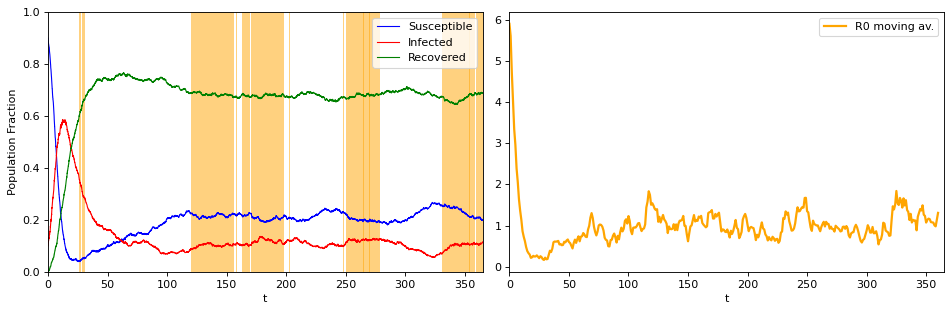

Total number of infections: 2936 people
Peak infections: 586 people
Total time in lockdown: 143 days
The model runtime was 55.38 seconds


In [10]:
####### Generate a random network according to given structure/parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import time
import numpy.random as ra
from numpy import linalg as LA # needed to compute eigenvalues, call w1, v1 = LA.eig(S_con1), w1 has the eigenvalues
import scipy.stats as stats
#import plotly.graph_objects as go
from matplotlib.pyplot import figure



### Set parameters (in days)

t0 = time.time()
N = 1000 # number of people
T_max = 365 # must be an integer
#reset_time = 499 # how often should the network be reset
beta = 0.02 # infection rate, S -> I 
gamma = 0.058 # recovery rate, I -> R
nu = 0.009 # loss of immunity rate, R -> S, can be set to zero if immunity is permanent 
i0 = 0.1 # proportion of population initially infected
lockdown_impact = 0.9 # reduce average contacts by this factor
average_contacts = 15

### Allocate people to households

F = decide_sizes(N,[[1, 2, 3, 4, 5, 6, 7],[0.2818, 0.3483, 0.1505, 0.1266, 0.058, 0.0227, 0.012]],0.3)
F_con = build_adjacency_new(N,F,1)

### Generate non-household contacts + build the network combining all contacts
lam = 18
ran = 0.1
NH_con = generate_contacts_poisson(lam,N)
A = NH_con + F_con
#A = (A>0)*1 # normalize the matrix, i.e. no double counting, comment out if you want weighted connections
G = nx.from_numpy_matrix(A, create_using=None) # create the network/graph object for the dynamics

### Run the SIR model on the generated network
n_path = 1 # number of paths to be simulated
prop='FANCY' # selects the algorithm for updating nodes
print(f'N={N}')

### Generate an initial condition for the simulation

I = [[int(i0*N)] for n in range(n_path)]
S = [[N-I[n][0]] for n in range(n_path)]
R = [[N-I[n][0]-S[n][0]] for n in range(n_path)]
X = np.array([1]*S[0][0] + [2]*I[0][0] + [3]*R[0][0]).reshape((N,1))
X = np.transpose(np.tile(X, (n_path,1,1)),(1,0,2)).reshape((N,n_path))
np.random.shuffle(X[:,:])

### Run the model

### evolve the model forward epoch by epoch, redrawing connections as necessary

lam_data = []
aveg_data = []
mini_data = []
maxi_data = []


I_total_maxi_data = []
I_total_mini_data = []
I_total_aveg_data = []

Imax_aveg_data = []
Imax_mini_data = []
Imax_maxi_data = []

Iaveg_aveg_data = []
Iaveg_mini_data = []
Iaveg_maxi_data = []

#current_epoch = reset_time

# initial run before the first network reset
model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC = X, prop = prop, sigma = nu, t0 = 0.0, T = T_max)
model.RunToConvergence()
times = model.times
S_data = model.S
I_data = model.I
R_data = model.R

for i in range(18, 19):
    # redraw network connections here
    lam = i
    ran = 0.1    
    summ = 0
    Imaxsum = 0
    Iavegsum = 0
    I_total_array = []
    sum_I_total_array = 0
    R0_data = []
    Imax_data = []
    Iaveg_data = []
    z = 1
    for j in range(1,z+1):
        times = np.append(times,model.times)
        lockdown_times = np.array([])
        relaxation_times = np.array([])
        R_0_data = []
        NH_con = generate_contacts_poisson(lam,N)
        A = NH_con + F_con
        G = nx.from_numpy_matrix(A, create_using=None)
        # run next epoch of the model
        I = [[int(i0*N)] for n in range(n_path)]
        S = [[N-I[n][0]] for n in range(n_path)]
        R = [[N-I[n][0]-S[n][0]] for n in range(n_path)]
        X = np.array([1]*S[0][0] + [2]*I[0][0] + [3]*R[0][0]).reshape((N,1))
        X = np.transpose(np.tile(X, (n_path,1,1)),(1,0,2)).reshape((N,n_path))
        np.random.shuffle(X[:,:])
        T_current = 0
        times = []
        S_data = []
        I_data = []
        R_data = []
        days_in_lockdown = 0
        while T_current < T_max:
            if T_current ==0:
                model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC=X, prop=prop, sigma=nu, t0=0.0, T = T_current+1)
                model.RunToConvergence()   
            else:
                model = SI_Simulation(G, lam=beta, phi=gamma, n_path=n_path, IC=model.X, prop=prop, sigma=nu, t0=model.times[-1], T = T_current+1)
                model.RunToConvergence()
        #print(model.I)
        #Use the diff of I_data to calculate the sum of infected people
            times = np.append(times,model.times)
            S_data = np.append(S_data,model.S)
            I_data = np.append(I_data,model.I)
            R_data = np.append(R_data,model.R)
            temp_infections = np.diff(model.I[0][:,0]) > 0
            if model.I[0,0][0]==0:
                R0=0
            else:
                R0 = (np.sum(temp_infections.astype(float))/model.I[0,0][0])/gamma
            #print(R0)
            R0_data = np.append(R0_data,R0)
            if T_current > 24:
                if avg_bigger(R0_data[max(T_current-25,0):T_current],1) == True:
                    lam = int(lockdown_impact*average_contacts)
                    lockdown_times = np.append(lockdown_times,np.max(times))
                    NH_con = generate_contacts_poisson(lam,N)
                    A = NH_con + F_con
                    G = nx.from_numpy_matrix(A, create_using=None)
                    days_in_lockdown = days_in_lockdown + 1
                elif avg_smaller(R0_data[max(T_current-25,0):T_current],0.8) == True:
                    lam = int(average_contacts) # relax the lockdown
                    NH_con = generate_contacts_poisson(lam,N)
                    A = NH_con + F_con
                    G = nx.from_numpy_matrix(A, create_using=None)
            T_current = T_current + 1
            
        ### Plotting
        #for n in range(n_path):
        figure(figsize=(12, 4), dpi=80)
        plt.subplot(1, 2, 1)
        plt.plot(times,S_data/model.N, 'b-', linewidth = 1, label='Susceptible');
        plt.plot(times,I_data/model.N, 'r-', linewidth = 1, label='Infected');
        plt.plot(times,R_data/model.N, 'g-', linewidth = 1, label='Recovered');
        plt.legend(loc="upper right")
        plt.xlabel('t')
        plt.xlim((0,T_max))
        plt.ylim((0,1))
        plt.ylabel('Population Fraction')
        # extra plotting to show the lockdown times
        dummy_var = np.zeros(np.size(lockdown_times))
        print(lockdown_times)
        for i in range(0,np.size(lockdown_times)-1):
            plt.axvspan(lockdown_times[i], lockdown_times[i]+1, facecolor='orange', alpha=0.5)
        
        
        plt.subplot(1, 2, 2)
        plt.plot(running_mean(R0_data,5), 'orange', linewidth = 2, label='R0 moving av.');
        plt.xlabel('t')
        plt.legend(loc="upper right")
        plt.xlim((0,T_max))
        plt.tight_layout()
        plt.show()


        v = np.diff(I_data) 
            #print(v)
        I_total_list = [ele for ele in v if ele > 0] 
            #print(I_total_list)
        I_total = np.sum(I_total_list)
        Iaveg = I_total/T_max

        I_total_array = np.append(I_total_array,I_total)
        #print(I_total_array)
        sum_I_total_array = sum_I_total_array + I_total

        Iaveg_data = np.append(Iaveg_data, Iaveg)
        Iavegsum = Iavegsum+Iaveg

        w, v = LA.eig(A)
        R0 = beta/gamma*max(w.real)
        R0_data = np.append(R0_data,R0)
        summ = summ + R0
        Imax = max(I_data)
            #print(Imax)
        Imax_data = np.append(Imax_data,Imax)
        Imaxsum = Imaxsum + Imax

print('Total number of infections: %3.0f people' % (I_total))    
print('Peak infections: %3.0f people' % (Imax))    
print('Total time in lockdown: %3.0f days' % (days_in_lockdown))    
print('The model runtime was %3.2f seconds' % (time.time() - t0))    
 

502.0


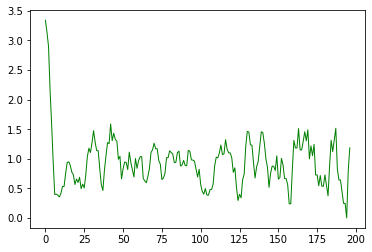

In [140]:
#print(lockdown_times)
#plt.plot(R0_data, 'g-', linewidth = 1, label='R0');
#plt.xlim((0,10))
#plt.show()
print(I_total)
temp = running_mean(R0_data,5)
plt.plot(temp, 'g-', linewidth = 1, label='R0');

# SIR_mean-field vectorialized

N=1000, n_path=10
0.0877685546875 seconds


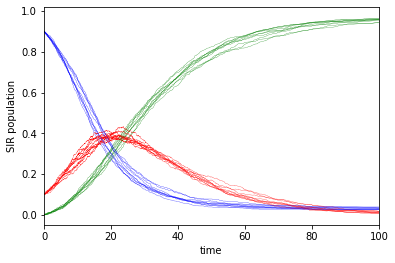

R_0 = 3.4482758620689657


In [142]:
# "vectorialized" = done in vector operations to run multiple paths of the simulation quickly
import math
import random
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib.colors import colorConverter as cc
import numpy as np
from datetime import datetime
import random
import time

t0 = time.time()


# Input parameters ####################
# int; total population
N = 1000
# float; maximum elapsed time
T = 100.0
# float; start time

# float; spatial parameter
V = N
# float; rate of infection after contact
_alpha = 0.2 # usually called beta, forced of infection
# float; rate of cure
_beta = 0.058 # recovery rate
# int; initial infected population


#Compute susceptible population, set recovered to zero

# Initialize results list


# number of paths
n_path = 10

# beginning simulation 
t_i = 0

t = np.array([0.0 for n in range(n_path)])

n_I = np.array([0.1*N for n in range(n_path)])
n_S = np.array([N - n_I[n] for n in range(n_path)])
n_R = np.array([0 for n in range(n_path)])

SIR_data = []
SIR_data.append(np.array((t, n_S, n_I, n_R)))

epsilon = 0.001*np.ones((n_path))

# random.seed()
rand_list = np.random.uniform(low=0.0,high=1.0,size=(2,n_path,3000))

 # Main loop
while (t < T).any():
    if (n_I == 0).all():
        break
        
    rand_dt = rand_list[0,:,t_i]
    rand_w = rand_list[1,:,t_i]

    w1 = _alpha * np.multiply(n_S[:],n_I[:]) / V
    w2 = _beta * n_I[:]
    W = w1 + w2 + epsilon
    # generate exponentially distributed random variable dt
    # using inverse transform sampling
    dt = -np.divide(np.log(np.ones(n_path) - rand_dt[:]), W[:])
    t = t + dt  
    t_i += 1
    for n in range(n_path):
        if n_I[n] != 0:
            if rand_w[n] < w1[n] / W[n]:
                n_S[n] -= 1
                n_I[n] += 1
            else:
                n_I[n] -= 1
                n_R[n] += 1
            
    SIR_data.append(np.array((t, n_S, n_I, n_R)))
#     with open("SIR_data.txt", "w+") as fp:
#         fp.write("\n".join("%f %i %i %i" % x for x in SIR_data))


print(f'N={N}, n_path={n_path}')
print(f'{time.time() - t0} seconds')


plt.figure(figsize=[6, 4])
for n in range(n_path):
    TT = np.array(SIR_data)[:,0,n]
    S = np.array(SIR_data)[:,1,n]
    I = np.array(SIR_data)[:,2,n]
    R = np.array(SIR_data)[:,3,n]    
    plt.plot(TT, S/N, color = 'b', linewidth = 0.25)
    plt.plot(TT, I/N, color = 'r', linewidth = 0.25)
    plt.plot(TT, R/N, color = 'g', linewidth = 0.25)
    plt.xlim((0,T))
    plt.xlabel("time")
    plt.ylabel("SIR population")

    #print(TT)
plt.show()  
print(f'R_0 = {_alpha/_beta}')